## Merge daily images
The output from planetlabs is several different rasters as the area of interest will be over multiple images. This is due to how the imagery was taken. The images must be combined together through the process of merge.


In [1]:
import os
import rasterio
import fiona
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.warp import calculate_default_transform, reproject, Resampling
import seaborn as sb
from itertools import chain
import rasterio.mask
import geopandas as gpd
import gdal
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tsraster.model  as md
import pandas as pd
from tsraster.calculate import calculateFeatures, image_to_series, \
                                exportFeatures
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

import dask
import dask.dataframe as dd
from dask.distributed import Client
from xml.dom import minidom

In [2]:
inpath = "../Images_new"


os.chdir(r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\NewCode')
from functions import merge_days, bai_rast_MS, ndvi_rast_MS, \
bai_rast_SR, ndvi_rast_SR, \
  merge_all_rast,find_unique_days,reproject_to_match, radiance_2_reflectance


## Create BAI and NDVI index


In [3]:
# Calculate NDVI and BAI 
inpath = "../Images_new"

name_pattern ='MS.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*SR.tif']


# create NDVI and BAI for each day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))

    iterator = 0

    for an_image in a_day_images_filtered:
        
        print(an_image)
        # get coefficients to convert radiance to reflectance 
        r2r_dictionary = radiance_2_reflectance(an_image)
        
        bai_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'bai',unique_day+"_"+str(iterator) + "_bai.tif"),
                r2r_dictionary = r2r_dictionary)
        
        ndvi_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'ndvi',unique_day +"_"+str(iterator) + "_ndvi.tif"),
                 r2r_dictionary=r2r_dictionary)
        
        iterator= iterator + 1 

Unique Dates: ['20161028', '20161027', '20161012', '20160828', '20161126', '20161213', '20161018', '20161121', '20161101']
../Images_new\20161028_044229_0e0f\20161028_044229_0e0f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.18443934316234298   0.4719778318270138
red band reflectance is 0.0 0.18443934316234298   0.3557089674737828


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


BAI band reflectance is nan nan   nan
../Images_new\20161028_044228_0e0f\20161028_044228_0e0f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1842800910086577   0.4303877784205102
red band reflectance is 0.0 0.1842800910086577   0.3999767461941907
BAI band reflectance is nan nan   nan
../Images_new\20161027_021505_0c62\20161027_021505_0c62_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.0   0.429046668170345
red band reflectance is 0.0 0.0   0.290717071525054
BAI band reflectance is nan nan   nan
../Images_new\20161027_020342_0c81\20161027_020342_0c81_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.0   0.444980365286742
red band reflectance is 0.0 0.0   0.352566755343297
BAI band reflectance is nan nan   nan
../Images_new\20161027_021506_0c62\20161027_021506_0c62_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.0   0.41381566316277596
red band reflectance is 0.0 0.0   0.32415501299403
BAI band reflectance is nan nan   nan
../Images_new\20161027_044323_0e0d\20161027_044323_0e0d_3B_Analyt

## Merge Same Days into Single File

In [4]:
 # MERGE SAME DAYS: Iterates through the unique list to select where files contain the same name and sets them up to be merged


# find all ndvi tifs 
name_pattern ='ndvi.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_ndvi_merge.tif",
               files_unique = a_day_images_filtered)



# find all bai tifs 
name_pattern ='bai.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_bai_merge.tif",
               files_unique = a_day_images_filtered)

Unique Dates: ['20161028', '20161027', '20161012', '20160828', '20161126', '20161213', '20161018', '20161121', '20161101']
File ../Images_new\ndvi\20161028_1_ndvi.tif
File ../Images_new\ndvi\20161028_0_ndvi.tif
mosiac shape:(1, 6884, 9439)
#################
Writing to ../Images_new/merge\20161028_ndvi_merge.tif
File ../Images_new\ndvi\20161027_4_ndvi.tif
File ../Images_new\ndvi\20161027_3_ndvi.tif
File ../Images_new\ndvi\20161027_7_ndvi.tif
File ../Images_new\ndvi\20161027_0_ndvi.tif
File ../Images_new\ndvi\20161027_8_ndvi.tif
File ../Images_new\ndvi\20161027_2_ndvi.tif
File ../Images_new\ndvi\20161027_6_ndvi.tif
File ../Images_new\ndvi\20161027_1_ndvi.tif
File ../Images_new\ndvi\20161027_5_ndvi.tif
File ../Images_new\ndvi\20161027_9_ndvi.tif
mosiac shape:(1, 13887, 13096)
#################
Writing to ../Images_new/merge\20161027_ndvi_merge.tif
File ../Images_new\ndvi\20161012_0_ndvi.tif
File ../Images_new\ndvi\20161012_1_ndvi.tif
File ../Images_new\ndvi\20161012_3_ndvi.tif
File ../Ima

## Create blank example raster


In [5]:
#%% Create blank example raster with full extent of all images 

# Selects the files using a unique identifier and sets up the out paths
 
all_bai = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))
outpath = os.path.join(inpath ,'combine', "all_merge.tif")


merge_all_rast(outpath, file_list=all_bai)



#%% Clip merged raster to shapefile to create example raster 


gdf= gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster.geojson")
gdf = gdf.to_crs({'init': 'epsg:32643'})
gdf.to_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", driver='GeoJSON')

with fiona.open(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", "r") as shapefile:
    print(shapefile.crs)
    feature = [feature["geometry"] for feature in shapefile]


with rasterio.open(os.path.join(inpath ,'combine', "all_merge.tif")) as src:
    out_image, out_transform = rasterio.mask.mask(src, feature,
                                                        crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
        
with rasterio.open(os.path.join(inpath ,'combine', "all_merge_clip.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

mosiac shape:(1, 15503, 23783)
{'init': 'epsg:32643'}


## Reproject and Resample
Make all images the same projection and extent of the empty raster

In [6]:
#%% reproject attempt 2 

all_images = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))+glob(os.path.join(inpath,'**/*bai_merge.tif'))
 
for image in all_images:
    example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
    out_name = os.path.join(inpath,'reproject', os.path.basename(image) )
    reproject_to_match(image, example_raster, out_name)
    

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB69F0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6B40> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6D20> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6E70> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6E70> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6D20> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6990> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB6D20> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015C2CEB69F0> >
<osgeo.gdal.Dataset;

## Convert from float to Int


In [ ]:
ndvi_images = glob(os.path.join(inpath,'reproject','*ndvi_merge.tif')) 

print(ndvi_images)
for image in ndvi_images:
    outpath  = os.path.join(inpath,'reproject','ndvi',os.path.basename(image))
    
    with rasterio.open(image) as src:
        data = src.read(1) * 10000
        data = data.astype(np.int16)

        data[np.isnan(data)]=-9999
        out_meta = src.profile 

        out_meta.update({"driver": "GTiff",
                      "count":1,
                      "dtype": 'int16',
                      'nodata':-9999
                      } )

    # Saves out the raster according to the below criteria
    with rasterio.open(outpath, 'w', **out_meta) as dst:
            dst.write(data.astype(rasterio.int16), 1)

In [20]:

bai_images =  glob(os.path.join(inpath,'reproject','*bai_merge.tif'))

for image in bai_images:
    outpath  = os.path.join(inpath,'reproject','bai',os.path.basename(image))

    with rasterio.open(image) as src:
        data = src.read(1) * 10000
        data = data.astype(np.int16)

        data[np.isnan(data)]=-9999

        out_meta = src.profile 

        out_meta.update({"driver": "GTiff",
                      "count":1,
                      "dtype": 'int16',
                      'nodata':-9999
                      } )

    # Saves out the raster according to the below criteria
    with rasterio.open(outpath, 'w', **out_meta) as dst:
            dst.write(data.astype(rasterio.int16), 1)
            

## Extract Statistics and Classification

Moved the final data to a new folder and renamed them baireproject_2018105.tif etc... 

In [4]:
#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2\my_df.csv


Merge peices together

In [5]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df3 =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(path,'my_df_no_missing.parquet') )

del my_df

In [5]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi",
                              'my_df_no_missing.parquet') )

del my_df

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
client = Client(n_workers=8, 
                processes=True, memory_limit='12GB')
client

In [8]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
#n = 1e6 # number of kbytes of target partition
#df.repartition(npartitions= 1+df.memory_usage(deep=True).sum().compute() // n )
df.npartitions


1200

In [9]:
bai_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 11032 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 16824 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 10128 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WAR

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 16468 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 16748 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 16576 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 12276 was killed by signal 15
distributed.nanny - WARN

In [10]:
bai_features.columns = ["_".join(x) for x in bai_features.columns.ravel()]
bai_features

,value_max,value_mean,value_min
pixel_id,,,
0,17936.0,9827.0,-22609.0
1,17936.0,11691.4,-13287.0
2,30159.0,20380.6,17936.0
3,30508.0,20450.4,17936.0
4,17936.0,17642.0,16466.0
5,17936.0,8175.6,-30866.0
6,23145.0,18977.8,17936.0
7,17936.0,15410.8,5310.0
8,17936.0,10590.4,-18792.0


In [11]:
bai_features.to_parquet(os.path.join(path,'bai_features.parquet'), compression ='UNCOMPRESSED')

In [12]:
bai_features.head()

,value_max,value_mean,value_min
pixel_id,,,
0,17936.0,9827.0,-22609.0
1,17936.0,11691.4,-13287.0
2,30159.0,20380.6,17936.0
3,30508.0,20450.4,17936.0
4,17936.0,17642.0,16466.0


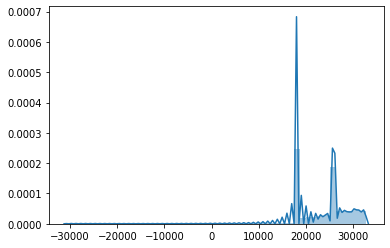

In [13]:
sb.distplot(bai_features.value_max.values)

In [14]:
client.close()
del bai_features

In [4]:
client = Client(n_workers=7, 
                processes=True, memory_limit='15GB')
client

Client Scheduler: tcp://127.0.0.1:56626 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 14 Memory: 105.00 GB


In [6]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
ndvi_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()
ndvi_features.columns = ["_".join(x) for x in ndvi_features.columns.ravel()]

ndvi_features.to_parquet(os.path.join(path,'ndvi_features.parquet'), compression ='UNCOMPRESSED' )
client.close()

In [7]:
ndvi_features.to_csv(os.path.join(path,'ndvi_features.csv'),chunksize = 10000)

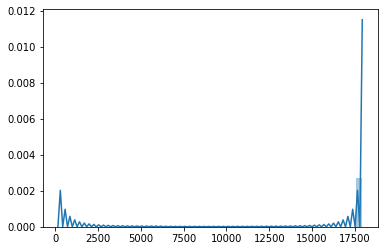

Future exception was never retrieved
future: <Future finished exception=TimeoutError('Timeout',)>
tornado.util.TimeoutError: Timeout


In [8]:
sb.distplot(ndvi_features.value_max.values)


## Combine BAI and NDVI features 

In [3]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject"
bai_features =  dd.read_parquet(os.path.join(path,'bai','bai_features.parquet'), index='pixel_id' )
bai_features.columns = ['bai_max', "bai_mean", 'bai_min']
ndvi_features =  dd.read_parquet(os.path.join(path,'ndvi','ndvi_features.parquet'), index='pixel_id' )
ndvi_features.columns = ['ndvi_max', "ndvi_mean", 'ndvi_min']


In [4]:
ndvi_features.persist()
bai_features.persist()


,bai_max,bai_mean,bai_min
npartitions=2,,,
0,float64,float64,float64
32917077,...,...,...
65834152,...,...,...


In [5]:
combined_features = dd.concat([bai_features, ndvi_features], axis=1).compute()


In [6]:
combined_features.head()

,bai_max,bai_mean,bai_min,ndvi_max,ndvi_mean,ndvi_min
pixel_id,,,,,,
0,17936.0,9827.0,-22609.0,17936.0,14806.444444,2851.0
1,17936.0,11691.4,-13287.0,17936.0,14786.777778,2765.0
2,30159.0,20380.6,17936.0,17936.0,14746.111111,2479.0
3,30508.0,20450.4,17936.0,17936.0,14684.222222,1975.0
4,17936.0,17642.0,16466.0,17936.0,14675.888889,1698.0


 ## Example unsupervised classification
 

In [21]:
# fit model
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-2).fit(
                bai_features.sample(
                    frac=0.2, random_state=1)
                )
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [22]:
# make predictions of classes to original data
class_preds = kmeans.predict(bai_features)

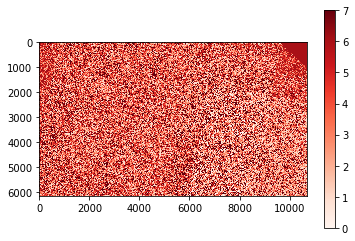

In [23]:
# convert classification  back to raster 
raster_ex = os.path.join(path,'ndvi','1','20160828_ndvi_merge.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [10]:
combined_features_scale.shape

(65834153, 6)

In [6]:
# center and scale
combined_features_scale = pd.DataFrame(StandardScaler().fit_transform(combined_features))

# fit model
db = DBSCAN(eps =1, min_samples =10, n_jobs = -2).fit(
                        combined_features_scale.sample(
                            frac=0.005, random_state=1)
            )


optics_preds = db.predict(combined_features_scale)

ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = optics_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


AttributeError: 'DBSCAN' object has no attribute 'predict'

## Example supervised classification
In this example I will make up an example training dataset and run the classifier on it. 

In [52]:
ts_features['Burned']=0
ts_features.loc[(ts_features.baireproj__maximum > 0.8e7) &
                (ts_features.baireproj__mean_change > 0) ,'Burned'] = 1
# isolate dependent variable and remove from independent variables
Burned = ts_features['Burned']
ts_features.drop(columns=['Burned'],inplace=True)
# print(Burned.head())
# print(ts_features.head())

In [53]:
obj = [Burned,ts_features]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False  )

input should be csv or pandas dataframe with yX, or [y,X]
reading in list concat on common index, inner join


In [54]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train, y_train)


In [55]:
predict_test = clf.predict(X=X_test)

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9999071434540778
Testing Kappa:  0.9995603042470054
Testing Conf: 
[[94766     0]
 [   10 12917]]


In [56]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

,importance
baireproj__mean_change,0.883521
baireproj__maximum,0.116479
baireproj__mean,0.000000
baireproj__mean_abs_change,0.000000
baireproj__median,0.000000
baireproj__minimum,0.000000
baireproj__standard_deviation,0.000000
baireproj__sum_values,0.000000


Make predictions back to the full original dataset

In [57]:
# make prediction of class
all_predict = md.model_predict(model = clf,
                                        new_X = ts_features)

# returns probability of each class
all_prob =  md.model_predict_prob(model = clf,
                                        new_X = ts_features)
print(all_predict.head())
print(all_prob.head())

pixel_id  time             
0         20181005_20181116    0
1         20181005_20181116    0
2         20181005_20181116    0
3         20181005_20181116    0
4         20181005_20181116    0
dtype: int64
                                   0         1
pixel_id time                                 
0        20181005_20181116  0.999887  0.000113
1        20181005_20181116  0.999887  0.000113
2        20181005_20181116  0.999887  0.000113
3        20181005_20181116  0.999887  0.000113
4        20181005_20181116  0.999887  0.000113


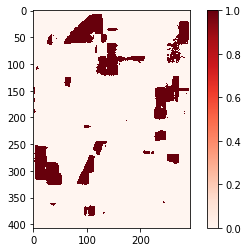

In [58]:
# convert classification  back to raster 

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_predict.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

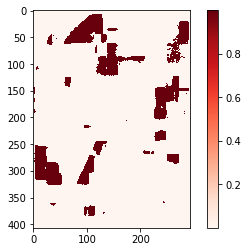

In [59]:
# convert classification PROBABILITY back to raster 

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_prob[1].values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()